In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utilities as util
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

In [53]:
def get_dataset():
    folder_path = "data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv"
    return pd.read_csv(folder_path, header=0)

In [54]:
df = get_dataset()
print(df.head())
print(df.describe())
print(len(df))

    Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980  4.39  4.39  4.39   4.39      0.455581                2.0   
2  1325318040  4.39  4.39  4.39   4.39      0.455581                2.0   
3  1325318100  4.39  4.39  4.39   4.39      0.455581                2.0   
4  1325318160  4.39  4.39  4.39   4.39      0.455581                2.0   

   Weighted_Price  
0            4.39  
1            4.39  
2            4.39  
3            4.39  
4            4.39  
          Timestamp          Open          High           Low         Close  \
count  3.273377e+06  3.273377e+06  3.273377e+06  3.273377e+06  3.273377e+06   
mean   1.423719e+09  1.282265e+03  1.283527e+03  1.280822e+03  1.282248e+03   
std    5.686463e+07  2.812084e+03  2.815636e+03  2.807936e+03  2.812042e+03   
min    1.325318e+09  3.800000e+00  3.800000e+00  1.500000e+00  1.500000e+00   
25%    1.374419e+09  1.178500e+02 

In [55]:
def clean_data(df, categorie):
    df['date'] = pd.to_datetime(df['Timestamp'], unit='s').dt.date
    group = df.groupby('date', as_index=False)
    weighted_price = group[categorie].mean()
    return weighted_price

In [56]:
cleaned_df = clean_data(df, 'Weighted_Price')
print(cleaned_df.head())
print(len(cleaned_df))

         date  Weighted_Price
0  2011-12-31        4.472579
1  2012-01-01        4.680778
2  2012-01-02        5.000000
3  2012-01-03        5.145917
4  2012-01-04        5.195443
2276


In [57]:
def plot_original_data(data):
    plt.figure(figsize=(10, 10))
    plt.plot(data.date, data.Weighted_Price, lw=1, label='Original Price')
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.savefig('original_data.png')
    plt.show()

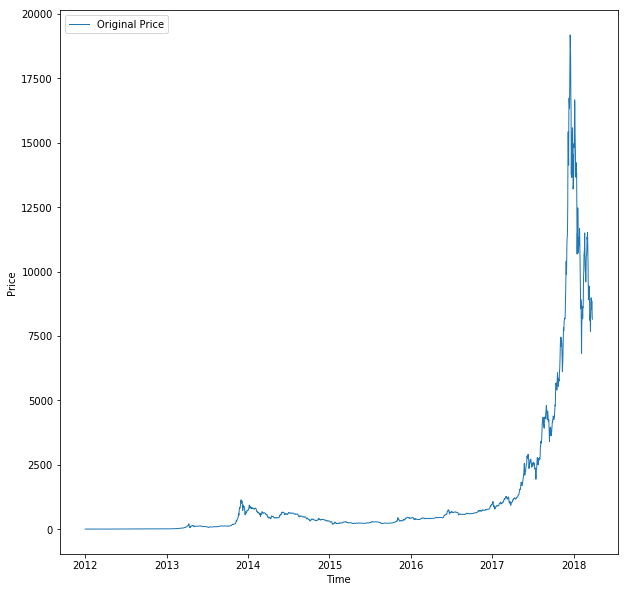

In [58]:
plot_original_data(cleaned_df)

In [59]:
weighted_price = cleaned_df.Weighted_Price.values.astype('float32')
print(weighted_price)
print(len(weighted_price))
weighted_price = weighted_price.reshape(len(weighted_price), 1)
print(weighted_price)

[4.4725790e+00 4.6807775e+00 5.0000000e+00 ... 8.5356084e+03 8.2080938e+03
 8.1551460e+03]
2276
[[4.4725790e+00]
 [4.6807775e+00]
 [5.0000000e+00]
 ...
 [8.5356084e+03]
 [8.2080938e+03]
 [8.1551460e+03]]


In [60]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(weighted_price)
print(data_scaled)
print(len(data_scaled))

[[7.4902200e-06]
 [1.8344159e-05]
 [3.4986078e-05]
 ...
 [4.4475812e-01]
 [4.2768389e-01]
 [4.2492360e-01]]
2276


In [61]:
def split_data(data, train_percentage):
    length_data = int(len(data))
    train_size = int(length_data * train_percentage)
    train_set = data[:train_size]
    test_set = data[train_size:]
    return train_set, test_set

In [62]:
train_set, test_set = util.split_data(data_scaled, train_percentage=0.85)
print(len(train_set))
print(len(test_set))

1934
342


In [63]:
def create_labels(data, look_back):
    look_back += 1
    seq_dataset = []
    for i in range(len(data) - look_back):
        seq_dataset.append(data[i: i + look_back])
    seq_dataset = np.array(seq_dataset)
    data_x = seq_dataset[:, :-1]
    data_y = seq_dataset[:, -1]
    return data_x, data_y

In [75]:
look_back = 10
x_train, y_train = util.create_labels(train_set, look_back)
print(x_train[:5])
print(y_train[:5])
print(len(x_train))
print(len(y_train))

[[[7.49022001e-06]
  [1.83441589e-05]
  [3.49860784e-05]
  [4.25930921e-05]
  [4.51750384e-05]
  [9.36053548e-05]
  [1.15321032e-04]
  [9.71397531e-05]
  [1.31029592e-04]
  [1.23487393e-04]]

 [[1.83441589e-05]
  [3.49860784e-05]
  [4.25930921e-05]
  [4.51750384e-05]
  [9.36053548e-05]
  [1.15321032e-04]
  [9.71397531e-05]
  [1.31029592e-04]
  [1.23487393e-04]
  [1.16219206e-04]]

 [[3.49860784e-05]
  [4.25930921e-05]
  [4.51750384e-05]
  [9.36053548e-05]
  [1.15321032e-04]
  [9.71397531e-05]
  [1.31029592e-04]
  [1.23487393e-04]
  [1.16219206e-04]
  [1.39578871e-04]]

 [[4.25930921e-05]
  [4.51750384e-05]
  [9.36053548e-05]
  [1.15321032e-04]
  [9.71397531e-05]
  [1.31029592e-04]
  [1.23487393e-04]
  [1.16219206e-04]
  [1.39578871e-04]
  [1.32847708e-04]]

 [[4.51750384e-05]
  [9.36053548e-05]
  [1.15321032e-04]
  [9.71397531e-05]
  [1.31029592e-04]
  [1.23487393e-04]
  [1.16219206e-04]
  [1.39578871e-04]
  [1.32847708e-04]
  [1.26777959e-04]]]
[[0.00011622]
 [0.00013958]
 [0.00013285

In [73]:
x_test, y_test = util.create_labels(test_set, look_back)
print(len(x_test))
print(len(y_test))
# print(x_test)
# print(y_test)

331
331


In [76]:
def build_model():
    model = Sequential()
    model.add(LSTM( input_shape=(None, 1),
                    units=50,
                    return_sequences=True))
    model.add(Dropout(0.35))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.35))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    model.summary()
    return model

In [77]:
model = util.build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [79]:
def train_model(model, x_train, y_train, epochs):
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.lstm.lookback10.hdf5',
                                   verbose=1,
                                   save_best_only=True)
    history = model.fit(x_train, y_train, batch_size=64,
                                epochs=epochs,
                                verbose=1,
                                validation_split=0.2,
                                callbacks=[checkpointer])
    return history

In [83]:
history = train_model(model, x_train, y_train, epochs=30)

Train on 1538 samples, validate on 385 samples
Epoch 1/30
1538/1538 [==============================] - 0s 257us/step - loss: 1.3617e-05 - val_loss: 4.4041e-05

Epoch 00001: val_loss improved from inf to 0.00004, saving model to saved_models/weights.best.lstm.lookback10.hdf5
Epoch 2/30
1538/1538 [==============================] - 0s 236us/step - loss: 1.4332e-05 - val_loss: 2.7746e-04

Epoch 00002: val_loss did not improve
Epoch 3/30
1538/1538 [==============================] - 0s 247us/step - loss: 1.7294e-05 - val_loss: 7.7610e-06

Epoch 00003: val_loss improved from 0.00004 to 0.00001, saving model to saved_models/weights.best.lstm.lookback10.hdf5
Epoch 4/30
1538/1538 [==============================] - 0s 261us/step - loss: 1.3641e-05 - val_loss: 4.2218e-05

Epoch 00004: val_loss did not improve
Epoch 5/30
1538/1538 [==============================] - 0s 265us/step - loss: 1.3296e-05 - val_loss: 5.8463e-06

Epoch 00005: val_loss improved from 0.00001 to 0.00001, saving model to saved_

In [ ]:
def plot_training_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('history.png')
    plt.show()

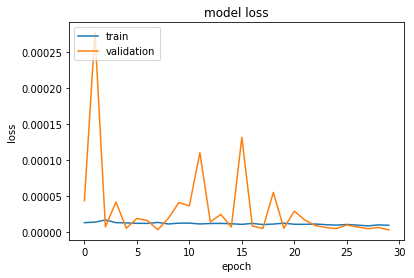

In [84]:
util.plot_training_history(history)

In [85]:
model.load_weights('saved_models/weights.best.lstm.lookback10.hdf5')

In [98]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
print(len(train_predict))
print(len(y_train))
print(len(test_predict))
print(len(y_test))

1923
1923
331
331
[0.00055939]


In [129]:
def accuracy(predictions, labels):
    result=0
    for prediction, label in zip(predictions, labels):
        result += (prediction - label)**2

    result = result/len(y_train)
    result = result[0]
    print('The mean squared error is : {}'.format(result))

In [130]:
accuracy(train_predict, y_train)
accuracy(test_predict, y_test)

The mean squared error is : 4.590871412801789e-06
The mean squared error is : 0.0005593851092271507


In [131]:
def plot_predicted_data(test_predict, train_predict, scaler, look_back, weighted_price):

    train_predict_unscaled = scaler.inverse_transform(train_predict)
    test_predict_unscaled = scaler.inverse_transform(test_predict)

    # CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
    trainPredictPlot = np.empty_like(weighted_price)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict_unscaled) + look_back, :] = train_predict_unscaled

    # CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
    testPredictPlot = np.empty_like(weighted_price)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict_unscaled) + (look_back * 2) + 1:len(weighted_price) - 1, :] = test_predict_unscaled

    plt.figure(figsize=(10, 10))
    plt.plot(weighted_price, 'g', label='original dataset')
    plt.plot(train_predict_unscaled, 'r', label='training set')
    plt.plot(testPredictPlot, 'b', label='predicted price/test set')
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Price')

#     plt.savefig('prediction.png')
    plt.show()

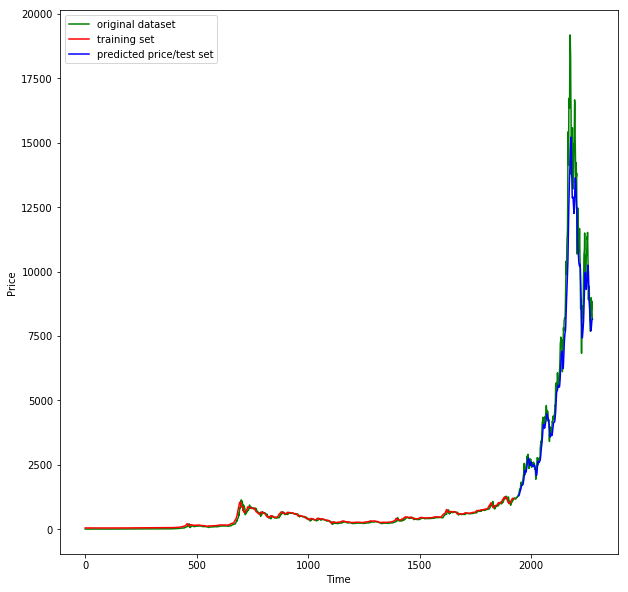

In [132]:
plot_predicted_data(test_predict, train_predict, scaler, look_back, weighted_price)